# Robustness evaluation: non-yearly data
### Rodrigo Leo
---

**Frequency (this fitting)**: monthly.

## Data preparation

In [60]:
# Import requiered libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kstest, anderson

# Prefix for saved plots:
px = 'freq_m'

# 'pub_quality' is a flag variable:
# - If true, automatically exports all plots to PDF at 200 dpi.
# - If false, all plots are displayed inline at 70 dpi.
pub_quality = False

if pub_quality:
    plt.rcParams['figure.dpi']= 200
else:
    plt.rcParams['figure.dpi']= 70

# Preferred style for the plotting engine
plt.style.use('seaborn-talk')

# Set a random seed
np.random.seed(0)

# Load data
data = pd.read_csv(f'databases/aggregated_m.csv')
data.head()

,Unnamed: 0,date,sp500_price,tbill,rpc_consumption,price
0,0,1954-02-16,25.809999,1.099667,831.5,26.977957
1,1,1954-03-31,26.940001,1.020333,831.5,26.927724
2,2,1954-05-13,28.559999,0.906667,831.5,26.862037
3,3,1954-06-25,29.200001,0.679333,831.5,26.956551
4,4,1954-08-09,30.120001,0.732000,831.5,26.837589


In [61]:
data['year'] = data['Unnamed: 0']
data['sp500'] = (data['sp500_price'] - data['sp500_price'].shift(1)) / data['sp500_price'].shift(1)
data['tbill'] = data['tbill'] / 100

In [62]:
# Name of the risky asset return column:
r_name = 'sp500'

# Name of the riskfree asset return column:
rf_name = 'tbill'

In [63]:
# Calculate inflation rate
data['inflation'] = (data['price'] - data['price'].shift(1)) / data['price'].shift(1)

# Calculate real returns on both assets
data['r'] = (1 + data[r_name]) / (1 + data['inflation'])
data['rf'] = (1 + data[rf_name])**(1/12) / (1 + data['inflation'])

# The risk premium is the difference beetween the return of the risky asset and the riskfree one
data['risk_premium'] = data['r'] - data['rf']

# Get data limits
x1 = min(data['year'])
x2 = max(data['year'])

data.head()

,Unnamed: 0,date,sp500_price,tbill,rpc_consumption,price,year,sp500,inflation,r,rf,risk_premium
0,0,1954-02-16,25.809999,0.010997,831.5,26.977957,0,NaN,NaN,NaN,NaN,NaN
1,1,1954-03-31,26.940001,0.010203,831.5,26.927724,1,0.043782,-0.001862,1.045729,1.002713,0.043015
2,2,1954-05-13,28.559999,0.009067,831.5,26.862037,2,0.060134,-0.002439,1.062726,1.003200,0.059526
3,3,1954-06-25,29.200001,0.006793,831.5,26.956551,3,0.022409,0.003518,1.018824,0.997056,0.021768
4,4,1954-08-09,30.120001,0.007320,831.5,26.837589,4,0.031507,-0.004413,1.036079,1.005043,0.031036


In [64]:
# Investmment period length (in years)
t_list = [1, 3, 5, 10]

# We will store the modified data in a dictionary called tdata
tdata = {t: None for t in t_list}

for t in t_list:
    years = list(data['year'])
    periods = []
    consumption = []
    r_returns = []
    rf_returns = []
    
    # Loop through the original data to form periods of length t
    for i in range(0, len(years) - t, t):
        # 'year_1' and 'year_2' are the starting and ending points of the period
        year_1 = years[i]
        year_2 = years[i + t - 1]
        periods.append((year_1, year_2))
        # 'sample' is the data from the current period
        sample = data.query('year >= ' + str(year_1) + ' & year <= ' + str(year_2))
        # Aggregate the consumption and return data
        consumption.append(sample['rpc_consumption'].sum())
        r_returns.append(sample['r'].product())
        rf_returns.append(sample['rf'].product())
        
    # Finally store the aggregated data in a tempral dataframe callen data_period
    data_period = pd.DataFrame({
        'year':        [period[1] for period in periods],
        'consumption': consumption,
        'r':           r_returns,
        'rf':          rf_returns
    })

    # Gross growth rate of per capita consumption and its logarithm
    data_period['delta_consumption_gross'] = data_period['consumption'] / data_period['consumption'].shift(1)
    data_period['log_delta_consumption_gross'] = np.log(data_period['delta_consumption_gross'])
    # Net growth rate of per capita consumption
    data_period['delta_consumption_net'] = data_period['delta_consumption_gross'] - 1
    # Long term (gross) risky return
    data_period['r2'] = data_period['r'] * data_period['r'].shift(1)
    # Set 'year' as index
    data_period = data_period.set_index('year')
    # And save
    tdata[t] = data_period

# Check if it worked
tdata[10].head()

,consumption,r,rf,delta_consumption_gross,log_delta_consumption_gross,delta_consumption_net,r2
year,,,,,,,
9,8394.336111,1.407911,1.013356,NaN,NaN,NaN,NaN
19,8806.540972,1.211050,1.008884,1.049105,0.047938,0.049105,1.705050
29,8901.087500,1.018386,0.980605,1.010736,0.010679,0.010736,1.233316
39,8880.641667,1.061623,0.994618,0.997703,-0.002300,-0.002297,1.081142
49,9155.681944,1.132779,1.009450,1.030971,0.030501,0.030971,1.202585


In [65]:
# Get the sample size for every t:
print('t\t', 'sample size')
for t in t_list:
    print(str(t) + '\t', len(tdata[t]))

t	 sample size
1	 555
3	 185
5	 111
10	 55


## Exploratory data analysis

In [66]:
# Set the index of the original data
data = data.set_index('year')

In [67]:
# Statistical summary of the returns over the whole series
data[['r', 'rf']].apply(lambda x: (x-1)*100).describe()

,r,rf
count,555.000000,555.000000
mean,0.618364,-0.063341
std,5.058797,0.380160
min,-26.731085,-1.424051
25%,-2.218372,-0.270102
50%,1.054352,-0.051675
75%,3.610734,0.151837
max,16.524565,2.654352


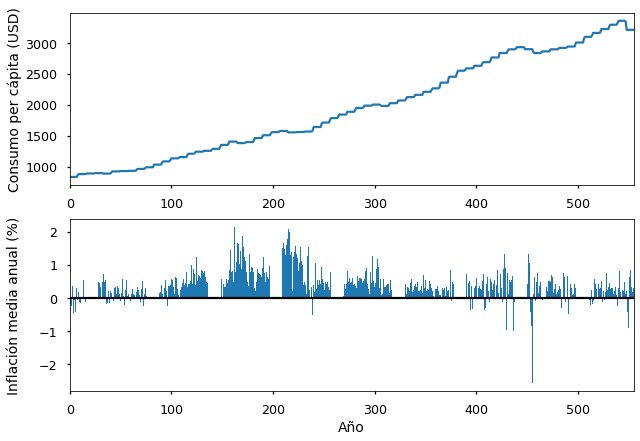

In [68]:
# Plot of real consumption per capita and inflation rate
fig = plt.figure()

plt.subplot(2, 1, 1)
plt.plot(data['rpc_consumption'])
axes = plt.gca()
axes.set_xlim([x1, x2])
plt.ylabel('Consumo per cápita (USD)')

plt.subplot(2, 1, 2)
plt.bar(data.index, data['inflation']*100)
plt.axhline(0, color='black', linestyle='-')
axes = plt.gca()
axes.set_xlim([x1, x2])
plt.ylabel('Inflación media anual (%)')

plt.xlabel('Año')
axes = plt.gca()
fig.align_ylabels()
if pub_quality: fig.savefig(f'figures/{px}_fig_consumo_inflacion.pdf', bbox_inches='tight')

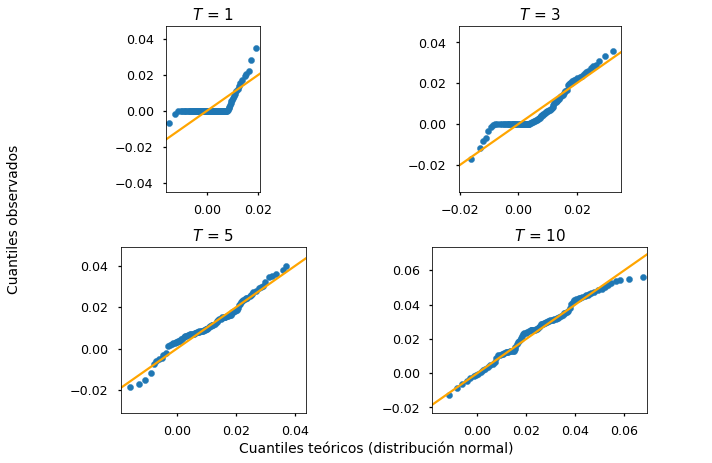

In [69]:
# The normality test results will be stored in a dictionary called 'normality_tests'
normality_tests = {t: None for t in t_list}

quants = {t: None for t in t_list}

quantiles = np.linspace(0,1,100)

for t in t_list:
    # Mean and standard deviation for the reference sample
    m = tdata[t]['log_delta_consumption_gross'].mean()
    s = tdata[t]['log_delta_consumption_gross'].std()

    # Test (data) sample
    test_sample = tdata[t]['log_delta_consumption_gross'].copy().dropna()
    normal_sample = pd.Series(np.random.normal(m, s, 1000))
    test_quantiles = test_sample.quantile(quantiles)
    normal_quantiles = normal_sample.quantile(quantiles)
    
    # Run some built-in normality tests
    normality_tests[t] = shapiro(test_sample), kstest(test_sample, 'norm', args=(m ,s)), anderson(test_sample, dist='norm')

    # Plot limits
    lim_inf = m - 2.5 * s
    lim_sup = m + 2.5 * s

    # Straight line
    straight = np.linspace(lim_inf, lim_sup, 10)
    
    quants[t] = {
        'test_quantiles': test_quantiles,
        'normal_quantiles': normal_quantiles,
        'straight': straight,
        'lim_inf': lim_inf,
        'lim_sup': lim_sup
    }    

t2axes = {
    1:  [0, 0],
    3:  [0, 1],
    5:  [1, 0],
    10: [1, 1]
}

# QQ plots
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.add_subplot(111, frame_on=False)

for t in t_list:
    axes[t2axes[t][0], t2axes[t][1]].plot(quants[t]['straight'], quants[t]['straight'], color='orange')
    axes[t2axes[t][0], t2axes[t][1]].scatter(quants[t]['normal_quantiles'], quants[t]['test_quantiles'], s=40)
    axes[t2axes[t][0], t2axes[t][1]].set_xlim([quants[t]['lim_inf'], quants[t]['lim_sup']])
    axes[t2axes[t][0], t2axes[t][1]].set_title('$T$ = ' + str(t))
    axes[t2axes[t][0], t2axes[t][1]].set_aspect(0.7)

plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Cuantiles teóricos (distribución normal)')
plt.ylabel('Cuantiles observados')

fig.tight_layout()

if pub_quality: fig.savefig(f'figures/{px}_fig_qqplots.pdf', bbox_inches='tight')

In [70]:
normality_results = pd.DataFrame({
    'T': t_list,
    'Shapiro-Wilks': [round(normality_tests[t][0].pvalue, 4) for t in t_list],
    'Kolmogorov-Smirnov': [round(normality_tests[t][1].pvalue, 4) for t in t_list]
})
normality_results = normality_results.set_index('T')
normality_results

,Shapiro-Wilks,Kolmogorov-Smirnov
T,,
1,0.0000,0.0000
3,0.0000,0.0000
5,0.0968,0.3516
10,0.5807,0.8732


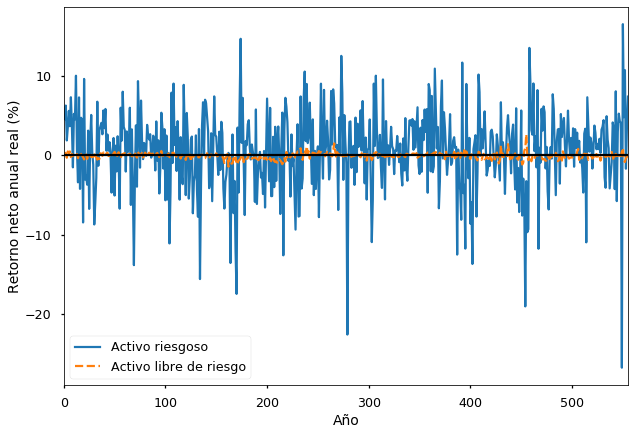

In [71]:
# Asset returns plot
fig = plt.figure()
plt.plot((data['r']-1)*100)
plt.plot((data['rf']-1)*100, linestyle='dashed')
plt.axhline(0, color='black', linestyle='-')
plt.legend(labels = ['Activo riesgoso', 'Activo libre de riesgo'])
plt.xlabel('Año')
plt.ylabel('Retorno neto anual real (%)')
axes = plt.gca()
axes.set_xlim([x1, x2])
if pub_quality: fig.savefig(f'figures/{px}_fig_retornos.pdf', bbox_inches='tight')

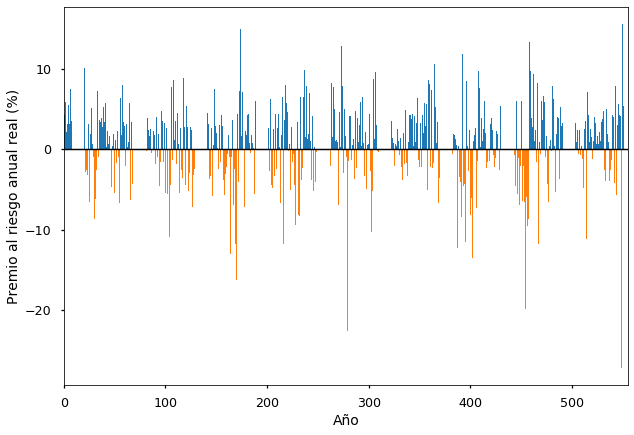

In [72]:
# Risk premium plot
fig = plt.figure()
plt.bar(data.query('risk_premium > 0').index, data.query('risk_premium > 0')['risk_premium']*100)
plt.bar(data.query('risk_premium < 0').index, data.query('risk_premium < 0')['risk_premium']*100)
plt.axhline(0, color='black', linestyle='-', linewidth=1.5)
plt.xlabel('Año')
plt.ylabel('Premio al riesgo anual real (%)')
axes = plt.gca()
axes.set_xlim([x1, x2])
if pub_quality: fig.savefig(f'figures/{px}_fig_premio_al_riesgo.pdf', bbox_inches='tight')

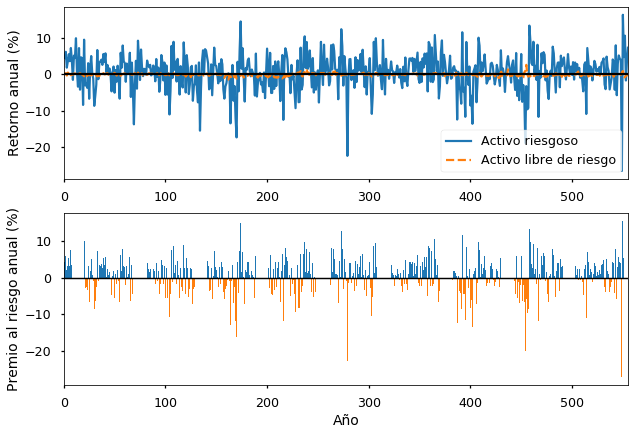

In [73]:
# Plot of real returns and risk premium
fig = plt.figure()

plt.subplot(2, 1, 1)
plt.plot((data['r']-1)*100)
plt.plot((data['rf']-1)*100, linestyle='dashed')
plt.axhline(0, color='black', linestyle='-')
axes = plt.gca()
axes.set_xlim([x1, x2])
plt.ylabel('Retorno anual (%)')
plt.legend(labels = ['Activo riesgoso', 'Activo libre de riesgo'])

plt.subplot(2, 1, 2)
plt.bar(data.query('risk_premium > 0').index, data.query('risk_premium > 0')['risk_premium']*100)
plt.bar(data.query('risk_premium < 0').index, data.query('risk_premium < 0')['risk_premium']*100)
plt.axhline(0, color='black', linestyle='-', linewidth=1.5)
axes = plt.gca()
axes.set_xlim([x1, x2])
plt.ylabel('Premio al riesgo anual (%)')

plt.xlabel('Año')
axes = plt.gca()
fig.align_ylabels()
if pub_quality: fig.savefig(f'figures/{px}_fig_retornos_premio.pdf', bbox_inches='tight')

## Model fitting

In [74]:
# Subjective discount factors (beta)
betas = [0.1, 0.5, 0.90, 0.95, 1.0]

# Maximum value of the relative risk aversion coefficient (gamma)
gamma_max = 150

# Subjective probabilities of not experiencing a consumption shock (pi_2)
pis = [0.2, 0.4, 0.6, 0.8, 1.0]

# Generate the sample space for gamma
points = 1000
gammas = np.linspace(0, gamma_max, points)

In [75]:
# The fitting results will be stored in a dictionary called 'treport'
treport = {t: None for t in t_list}

for t in t_list:
    # Mean returns
    r  = tdata[t]['r'].mean()
    rf = tdata[t]['rf'].mean()

    # Standard deviations
    sr  = tdata[t]['r'].std()
    sr2 = tdata[t]['r2'].std()

    # Mean and standard deviation of the rate of growth of consumption
    mc = tdata[t]['delta_consumption_gross'].mean() - 1
    sc = tdata[t]['delta_consumption_gross'].std()

    # The estimation of the return of the risky asset is stored in the dictioonary 'report'
    # Each key corresponds to a value of the beta parameter
    report = {beta: None for beta in betas}

    # Estimation of the return of the risky asset
    for beta in betas:
        # For each value of beta, the estimation is stored in a temporary dataframe called 'results'
        results = pd.DataFrame({'gamma': gammas})
        # Loop over the values of the pi parameter
        for pi in pis:
            # For each value of pi, the estimation is stored in 'result'
            result = []
            for gamma in gammas:
                # Calculate the first and second central moments of the delta discount factor
                md1 = beta * np.exp(- gamma * mc + gamma ** 2 * sc ** 2 / 2)
                md2 = beta ** 2 * np.exp(- 2 * gamma * mc + gamma ** 2 * sc ** 2)
                sd1 = np.sqrt(beta ** 2 * np.exp(- 2 * gamma * mc + gamma ** 2 * sc ** 2) * (np.exp(gamma ** 2 * sc ** 2) - 1))
                sd2 = np.sqrt(beta ** 4 * np.exp(- 4 * gamma * mc + 2 * gamma ** 2 * sc ** 2) * (np.exp(2 * gamma ** 2 * sc ** 2) - 1))
                # Auxiliary factor c
                c = (pi - 1) * sd1 * sr - pi ** 2 * sd2 * sr2 - md1 * rf - pi * md2 * rf ** 2
                # Estimator
                r_estimation = (- md1 + np.sqrt(md1 ** 2 - 4 * pi * md2 * c)) / (2 * pi * md2)
                # The estimator is annualized for an easier interpretation
                r_estimation = r_estimation ** (1 / t)
                # Store
                result.append((r_estimation - 1) * 100)
            # Store
            results[str(pi)] = result
        # Store
        report[beta] = results
    # Store
    treport[t] = report

# Take a look
treport[1][0.95].head()

,gamma,0.2,0.4,0.6,0.8,1.0
0,0.000000,-0.062823,-0.062823,-0.062823,-0.062823,-0.062823
1,0.150150,-0.059232,-0.059901,-0.059922,-0.059589,-0.059041
2,0.300300,-0.055640,-0.056978,-0.057022,-0.056356,-0.055260
3,0.450450,-0.052048,-0.054056,-0.054122,-0.053124,-0.051480
4,0.600601,-0.048456,-0.051134,-0.051223,-0.049893,-0.047702


In [76]:
# Line markers for each probability (this is just styling stuff)
markers = {
    0.2: '$A$',
    0.4: '$B$',
    0.6: '$C$',
    0.8: '$D$',
    1.0: '$E$'
}

# Override markers
markers = {pi: None for pi in pis}

# Labels for each probability
labels = ['$\pi_2 = $' + str(pi) for pi in pis]

# Plotting function
def graph(T, beta):
    fig = plt.figure()
    for pi in pis:
        plt.plot(gammas, treport[t][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(700,2000), markerfacecolor='black')
    plt.axhline((data['r'].mean() ** 12 - 1) * 100, color='black', linestyle='dashed')
    plt.axhline((data['rf'].mean() - 1) * 100, color='black', linestyle='dotted')
    plt.xlabel('Coeficiente de aversión relativa al riesgo')
    plt.ylabel('Retorno neto anualizado (%)')
    plt.legend(labels = labels + ['Activo riesgoso (media)', 'Activo sin riesgo (media)'], bbox_to_anchor=(0.5, -0.37), loc='lower center', ncol=3)
    plt.grid(linestyle="-", linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0, 140])
    axes.set_ylim([-1, 9])
    plt.title('$T$ = ' + str(t))
    plt.axvspan(0, 10, alpha=0.1, color='black')
    if pub_quality: fig.savefig(f'figures/{px}_fig_resultados_beta_' + str(int(100 * beta)) + '_t_' + str(t) + '.pdf', bbox_inches='tight')

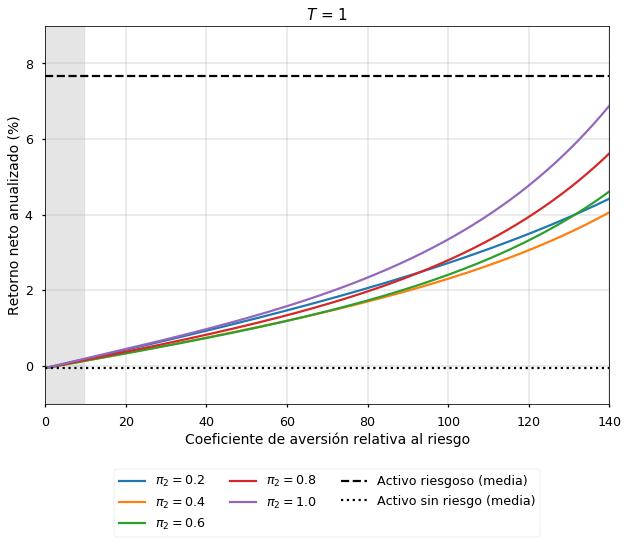

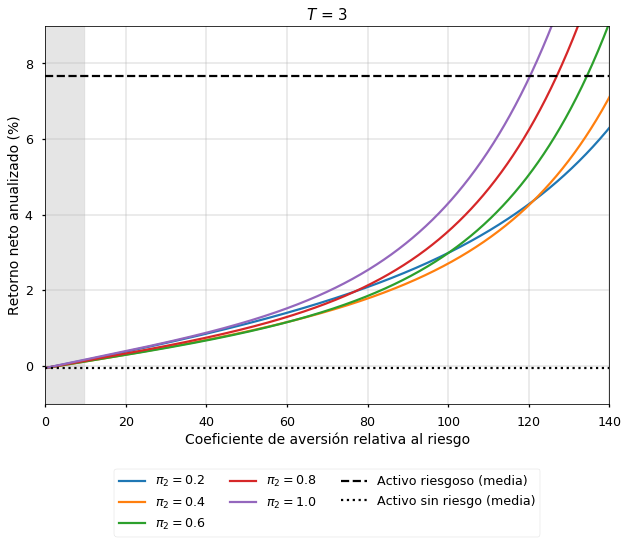

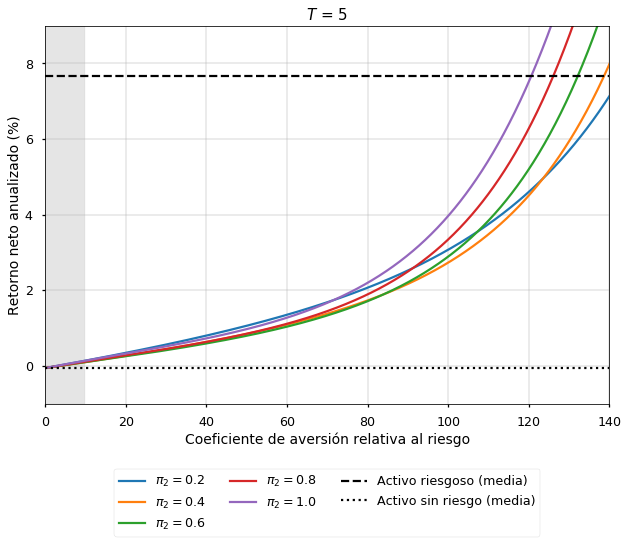

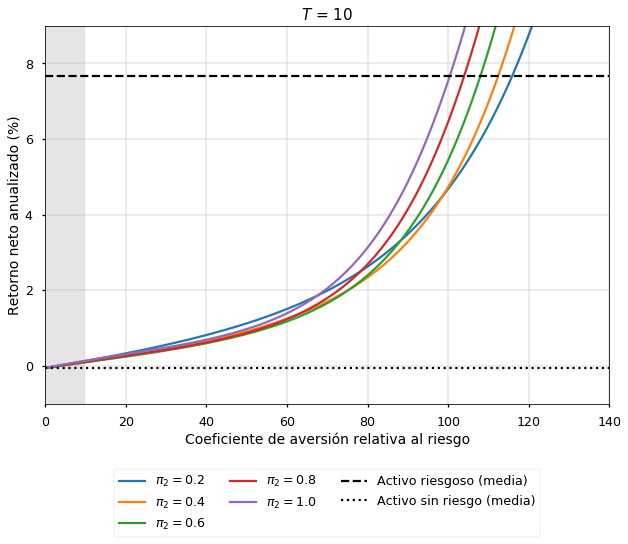

In [81]:
# Plot the results for the given value of beta
beta = 0.95
for t in t_list:
    graph(t, beta)

<Figure size 728x500.5 with 0 Axes>

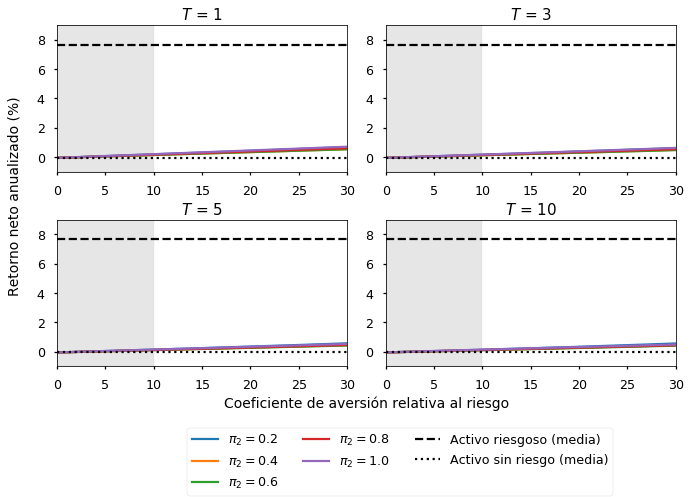

In [78]:
# A more compact plot
plt.gcf().clear()
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.add_subplot(111, frame_on=False)

beta = 0.95

for pi in pis:
    axes[0, 0].plot(gammas, treport[1][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[0, 1].plot(gammas, treport[3][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 1].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 0].plot(gammas, treport[5][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 1].plot(gammas, treport[10][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 1].axvspan(0, 10, alpha=0.04, color='gray')

for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].axhline((data['r'].mean() ** 12 - 1) * 100, color='black', linestyle='dashed')
        axes[i, j].axhline((data['rf'].mean() - 1) * 100, color='black', linestyle='dotted')

axes[0, 0].set_title('$T$ = 1')
axes[0, 1].set_title('$T$ = 3')
axes[1, 0].set_title('$T$ = 5')
axes[1, 1].set_title('$T$ = 10')

plt.setp(axes, xlim=(0, 30), ylim=(-1, 9))
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Coeficiente de aversión relativa al riesgo')
plt.ylabel('Retorno neto anualizado (%)')

fig.legend(labels = labels + ['Activo riesgoso (media)', 'Activo sin riesgo (media)'], bbox_to_anchor=(0.55, -0.01), loc='lower center', ncol=3)
fig.tight_layout()

fig.subplots_adjust(bottom=0.25)

if pub_quality: fig.savefig(f'figures/{px}_fig_resultados_comparativo_beta_' + str(int(100 * beta)) + '.pdf', bbox_inches='tight')

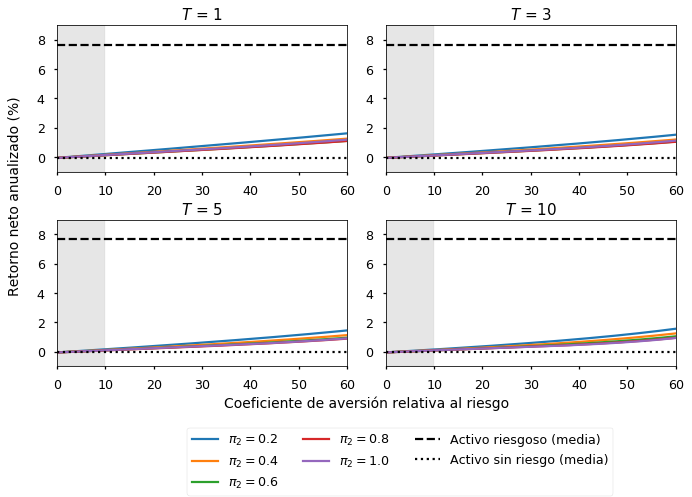

In [79]:
str(int(100 * beta))# A more compact plot
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.add_subplot(111, frame_on=False)

beta = 0.5

for pi in pis:
    axes[0, 0].plot(gammas, treport[1][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[0, 1].plot(gammas, treport[3][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 1].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 0].plot(gammas, treport[5][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 1].plot(gammas, treport[10][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 1].axvspan(0, 10, alpha=0.04, color='gray')

for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].axhline((data['r'].mean() ** 12 - 1) * 100, color='black', linestyle='dashed')
        axes[i, j].axhline((data['rf'].mean() - 1) * 100, color='black', linestyle='dotted')
        #axes[i, j].grid(linestyle="-", linewidth=0.5)

axes[0, 0].set_title('$T$ = 1')
axes[0, 1].set_title('$T$ = 3')
axes[1, 0].set_title('$T$ = 5')
axes[1, 1].set_title('$T$ = 10')

plt.setp(axes, xlim=(0,60), ylim=(-1, 9))
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Coeficiente de aversión relativa al riesgo')
plt.ylabel('Retorno neto anualizado (%)')

fig.legend(labels = labels + ['Activo riesgoso (media)', 'Activo sin riesgo (media)'], bbox_to_anchor=(0.55, -0.01), loc='lower center', ncol=3)
fig.tight_layout()

fig.subplots_adjust(bottom=0.25)

if pub_quality: fig.savefig(f'figures/{px}_fig_resultados_comparativo_beta_' + str(int(100 * beta)) + '.pdf', bbox_inches='tight')

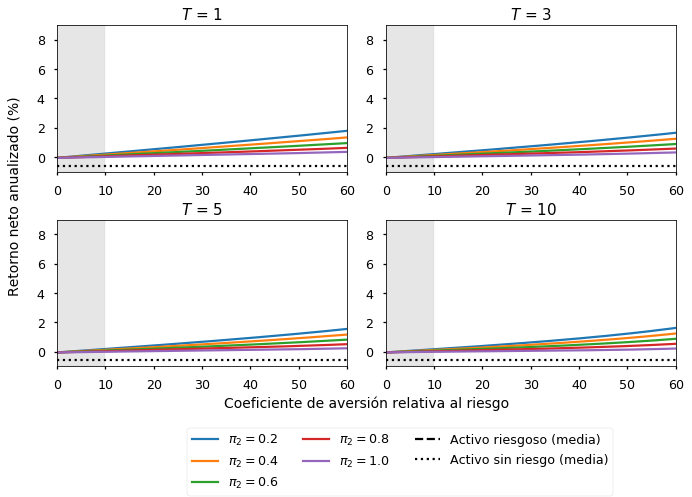

In [80]:
# A more compact plot
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.add_subplot(111, frame_on=False)

beta = 0.1

for pi in pis:
    axes[0, 0].plot(gammas, treport[1][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[0, 1].plot(gammas, treport[3][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 1].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 0].plot(gammas, treport[5][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 1].plot(gammas, treport[10][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 1].axvspan(0, 10, alpha=0.04, color='gray')

for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].axhline((tdata[t]['r'].mean() ** 12 - 1) * 100, color='black', linestyle='dashed')
        axes[i, j].axhline((tdata[t]['rf'].mean() - 1) * 100, color='black', linestyle='dotted')
        #axes[i, j].grid(linestyle="-", linewidth=0.5)

axes[0, 0].set_title('$T$ = 1')
axes[0, 1].set_title('$T$ = 3')
axes[1, 0].set_title('$T$ = 5')
axes[1, 1].set_title('$T$ = 10')

plt.setp(axes, xlim=(0,60), ylim=(-1, 9))
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Coeficiente de aversión relativa al riesgo')
plt.ylabel('Retorno neto anualizado (%)')

fig.legend(labels = labels + ['Activo riesgoso (media)', 'Activo sin riesgo (media)'], bbox_to_anchor=(0.55, -0.01), loc='lower center', ncol=3)
fig.tight_layout()

fig.subplots_adjust(bottom=0.25)

if pub_quality: fig.savefig(f'figures/{px}_fig_resultados_comparativo_beta_' + str(int(100 * beta)) + '.pdf', bbox_inches='tight')